# Creating the Gene Table

A copy of this notebook is available on the PyModulon GitHub page: [Creating the Gene Table Notebook](https://github.com/SBRG/pymodulon/blob/master/docs/tutorials/creating_the_gene_table.ipynb)

First, download the FASTA and GFF files for your organism and its plasmids from NCBI. We will use the *E. coli* K-12 MG1655 strain as an example, which does not have plasmids.

In [2]:
from pymodulon import example_data

## Get information from GFF files

In [3]:
from pymodulon.gene_util import *

Enter the location of all your GFF files here:

In [4]:
gff_files = [example_data.ecoli_gff]

The following cell will convert all the GFF files into a single Pandas DataFrame for easy manipulation. Pseudogenes have multiple rows in a GFF file (one for each fragment), but only the first fragment will be kept.

In [5]:
keep_cols = ['accession','start','end','strand','gene_name','old_locus_tag','gene_product','ncbi_protein']

DF_annot = gff2pandas(gff_files,index='locus_tag')
DF_annot = DF_annot[keep_cols]

DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
b0001,NC_000913.3,190,255,+,thrL,None,thr operon leader peptide,NP_414542.1
b0002,NC_000913.3,337,2799,+,thrA,None,fused aspartate kinase/homoserine dehydrogenase 1,NP_414543.1
b0003,NC_000913.3,2801,3733,+,thrB,None,homoserine kinase,NP_414544.1
b0004,NC_000913.3,3734,5020,+,thrC,None,threonine synthase,NP_414545.1
b0005,NC_000913.3,5234,5530,+,yaaX,None,DUF2502 domain-containing protein YaaX,NP_414546.1


To ensure that the gene index used is identical to the expression matrix, load in your data.

In [6]:
DF_log_tpm = example_data.load_example_log_tpm()
DF_log_tpm.head()

,ecoli_00001,ecoli_00002,ecoli_00009,ecoli_00010
Geneid,,,,
b0001,10.473721,10.271944,10.315476,10.808135
b0002,10.260569,10.368555,10.735874,10.726916
b0003,9.920277,10.044224,10.528432,10.503092
b0004,9.936694,10.010638,9.739519,9.722997
b0005,7.027515,7.237449,6.745798,6.497823


Check that the genes are the same in the expression dataset as in the annotation dataframe. Mismatched genes are listed below.

In [7]:
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## (Optional) KEGG and COGs

### Generate nucleotide fasta files for CDS

Enter the location of all your fasta files here:

In [8]:
fasta_files = [example_data.ecoli_fasta]

The following code generates CDS files using your FASTA and GFF3 files

In [9]:
from Bio import SeqIO

cds_list = []
for fasta in fasta_files:
    seq = SeqIO.read(fasta,'fasta')

    # Get gene information for genes in this fasta file
    df_genes = DF_annot[DF_annot.accession == seq.id]
    
    for i,row in df_genes.iterrows():
        cds = seq[row.start-1:row.end]
        if row.strand == '-':
            cds = seq[row.start-1:row.end].reverse_complement()
        cds.id = row.name
        cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
        cds_list.append(cds)

In [10]:
cds_list[:5]

[SeqRecord(seq=Seq('ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAAC...TGA', SingleLetterAlphabet()), id='b0001', name='NC_000913.3', description='thrL', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTG...TGA', SingleLetterAlphabet()), id='b0002', name='NC_000913.3', description='thrA', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCGGGTTTGAT...TAA', SingleLetterAlphabet()), id='b0003', name='NC_000913.3', description='thrB', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTGCGCAAGCC...TAA', SingleLetterAlphabet()), id='b0004', name='NC_000913.3', description='thrC', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGGTCGCTCCC...TAA', SingleLetterAlphabet()), id='b0005', name='NC_000913.3', description='yaaX', dbxrefs=[])]

Uncomment the line below to write the CDS file

In [11]:
# SeqIO.write(cds_list,'CDS.fna','fasta')

### Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file

### Get KEGG IDs

Once you have the EggNOG annotations, load the annotation file

In [12]:
eggnog_file = example_data.ecoli_eggnog

In [13]:
DF_eggnog = pd.read_csv(eggnog_file,sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

DF_eggnog.head()

,seed eggNOG ortholog,seed ortholog evalue,seed ortholog score,Predicted taxonomic group,Predicted protein name,Gene Ontology terms,EC number,KEGG_orth,KEGG_pathway,KEGG_module,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG Reaction,tax_scope,eggNOG OGs,bestOG_deprecated,COG,eggNOG free text description
locus_tag,,,,,,,,,,,,,,,,,,,,,
b0002,316407.85674276,0.000000e+00,1600.5,Escherichia,thrA,"GO:0003674,GO:0003824,GO:0004072,GO:0004412,GO...","1.1.1.3,2.7.2.4",ko:K12524,"ko00260,ko00261,ko00270,ko00300,ko01100,ko0111...","M00016,M00017,M00018,M00526,M00527",...,"RC00002,RC00043,RC00087","ko00000,ko00001,ko00002,ko01000",NaN,NaN,"iECDH1ME8569_1439.ECDH1ME8569_0002,iEcDH1_1363...",Escherichia,"1MW3H@1224,1RN1G@1236,3XN2A@561,COG0460@1,COG0...",NA|NA|NA,E,homoserine dehydrogenase I
b0003,316407.85674277,3.000000e-178,630.9,Escherichia,thrB,"GO:0000096,GO:0000097,GO:0003674,GO:0003824,GO...",2.7.1.39,ko:K00872,"ko00260,ko01100,ko01110,ko01120,ko01230,map002...",M00018,...,"RC00002,RC00017","ko00000,ko00001,ko00002,ko01000",NaN,NaN,iECSE_1348.ECSE_0003,Escherichia,"1MW8I@1224,1RMYR@1236,3XN01@561,COG0083@1,COG0...",NA|NA|NA,F,Catalyzes the ATP-dependent phosphorylation of...
b0004,316407.21321894,1.200000e-246,858.6,Escherichia,thrC,"GO:0003674,GO:0003824,GO:0004795,GO:0005575,GO...",4.2.3.1,ko:K01733,"ko00260,ko00750,ko01100,ko01110,ko01120,ko0123...",M00018,...,"RC00017,RC00526","ko00000,ko00001,ko00002,ko01000",NaN,NaN,"iLF82_1304.LF82_2261,iNRG857_1313.NRG857_00025",Escherichia,"1MUWQ@1224,1RQ0H@1236,3XP31@561,COG0498@1,COG0...",NA|NA|NA,E,Catalyzes the gamma-elimination of phosphate f...
b0005,316407.21321895,1.400000e-23,115.5,Escherichia,yaaX,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Escherichia,"1N4SV@1224,1S9KR@1236,2B58A@1,32XJS@2,3XRGB@561",NA|NA|NA,S,Protein of unknown function (DUF2502)
b0006,198214.SF0006,1.600000e-143,515.4,Gammaproteobacteria,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Escherichia,"1MUAF@1224,1RMTD@1236,COG3022@1,COG3022@2",NA|NA|NA,S,Belongs to the UPF0246 family


Now we will pull the KEGG information from the eggNOG file, including orthology, pathway, module, and reactions for each gene.

In [14]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
2750,b0002,KEGG_pathway,map00260
2751,b0002,KEGG_pathway,map00261
2752,b0002,KEGG_pathway,map00270
2753,b0002,KEGG_pathway,map00300
2754,b0002,KEGG_pathway,map01100


### Save KEGG information

Uncomment the line below to save the KEGG file

In [15]:
# DF_kegg.to_csv('kegg_mapping.csv')

### Save COGs to annotation dataframe

In [16]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

## Uniprot ID mapping

The ``uniprot_id_mapping`` function is a python wrapper for the [Uniprot ID mapping tool](https://www.uniprot.org/uploadlists/). Use ``input_id=P_REFSEQ_AC`` if the FASTA/GFFf files are from RefSeq, and ``input_id=EMBL`` if the files are from Genbank.

In [17]:
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='P_REFSEQ_AC',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')
mapping_uniprot.head()

,ncbi_protein,uniprot
2090,NP_416515.1,A0A0G3HGF9
4381,NP_418733.1,A0A0N9YI43
3651,NP_418014.1,A0A223DQZ5
26,NP_414563.1,A0A385XJ53
1978,NP_416408.1,A0A385XJ53


In [18]:
# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
b0001,NC_000913.3,190,255,+,thrL,None,thr operon leader peptide,NP_414542.1,NaN,P0AD86
b0002,NC_000913.3,337,2799,+,thrA,None,fused aspartate kinase/homoserine dehydrogenase 1,NP_414543.1,E,P00561
b0003,NC_000913.3,2801,3733,+,thrB,None,homoserine kinase,NP_414544.1,F,P00547
b0004,NC_000913.3,3734,5020,+,thrC,None,threonine synthase,NP_414545.1,E,P00934
b0005,NC_000913.3,5234,5530,+,yaaX,None,DUF2502 domain-containing protein YaaX,NP_414546.1,S,P75616


## Add Biocyc Operon information

To obtain operon information from Biocyc, follow the steps below

1. Go to [Biocyc.org](https://biocyc.org/) (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select **SmartTables** -> **Special SmartTables**
4. Select **"All genes of \<organism\>"**
5. Select the **"Gene Name"** column
6. Under **"ADD TRANSFORM COLUMN"** select **"Genes in same transcription unit"**
7. Select the **"Genes in same transcription unit"** column
8. Under **"ADD PROPERTY COLUMN"** select **"Accession-1"**
9. Under **OPERATIONS**, select **"Export"** -> **"to Spreadsheet File..."**
10. Select **"common names"** and click **"Export smarttable"**
11. Add file location below and run the code cell

In [19]:
biocyc_file = example_data.ecoli_biocyc

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')

# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Accession-1.1'].apply(reformat_biocyc_tu)

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list
locus_tag,,,,,,,
b0001,thrL,190.0,255.0,<i>thr</i> operon leader peptide,thrL // thrA // thrB // thrC,b0001 // b0002 // b0003 // b0004,b0001;b0002;b0003;b0004
b0002,thrA,337.0,2799.0,fused aspartate kinase/homoserine dehydrogenase 1,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004
b0003,thrB,2801.0,3733.0,homoserine kinase,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004
b0004,thrC,3734.0,5020.0,threonine synthase,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004
b0005,yaaX,5234.0,5530.0,DUF2502 domain-containing protein YaaX,yaaX,b0005,b0005


### Assign unique IDs to operons

The following code assigns unique names to each operon

In [20]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list,operon
locus_tag,,,,,,,,
b0001,thrL,190.0,255.0,<i>thr</i> operon leader peptide,thrL // thrA // thrB // thrC,b0001 // b0002 // b0003 // b0004,b0001;b0002;b0003;b0004,Op0
b0002,thrA,337.0,2799.0,fused aspartate kinase/homoserine dehydrogenase 1,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004,Op0
b0003,thrB,2801.0,3733.0,homoserine kinase,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004,Op0
b0004,thrC,3734.0,5020.0,threonine synthase,thrA // thrB // thrC // thrL,b0002 // b0003 // b0004 // b0001,b0001;b0002;b0003;b0004,Op0
b0005,yaaX,5234.0,5530.0,DUF2502 domain-containing protein YaaX,yaaX,b0005,b0005,Op1


Finally, merge the Biocyc information with the main annotation DataFrame

In [21]:
DF_annot['operon'] = DF_biocyc['operon']

## Clean up and save annotation

First, we will re-order the annotation columns

In [22]:
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','uniprot','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','uniprot','operon']
    
DF_annot = DF_annot[order]

In [23]:
DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
b0001,thrL,NC_000913.3,None,190,255,+,thr operon leader peptide,NaN,P0AD86,Op0
b0002,thrA,NC_000913.3,None,337,2799,+,fused aspartate kinase/homoserine dehydrogenase 1,E,P00561,Op0
b0003,thrB,NC_000913.3,None,2801,3733,+,homoserine kinase,F,P00547,Op0
b0004,thrC,NC_000913.3,None,3734,5020,+,threonine synthase,E,P00934,Op0
b0005,yaaX,NC_000913.3,None,5234,5530,+,DUF2502 domain-containing protein YaaX,S,P75616,Op1


## Final statistics

The following graphs show how much information is available for the organism.

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

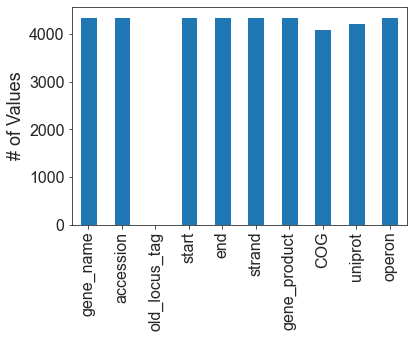

In [25]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

Some organisms are missing gene names, so these will be filled with locus tag gene names.

In [26]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

 COG letters will also be converted to the full name.

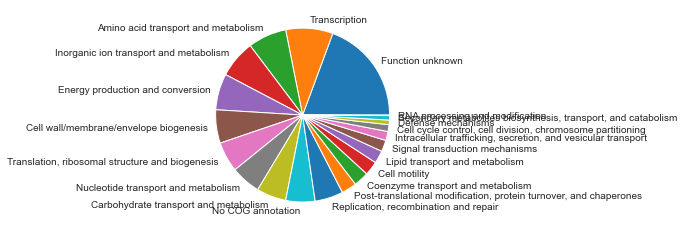

In [27]:
# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

Uncomment the following line to save the gene annotation dataset

In [28]:
# DF_annot.to_csv('gene_info.csv')

## GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2

1. Go to [AmiGO 2](http://amigo.geneontology.org/amigo/search/annotation)
1. Filter for your organism
1. Click ``CustomDL``
1. Drag ``GO class (direct)`` to the end of your Selected Fields
1. Enter the location of your GO annotation file below and run the following code block

In [29]:
go_file = example_data.ecoli_go_example

In [30]:
DF_GO = pd.read_csv(go_file,sep='\t',header=None,usecols=[2,10,17])
DF_GO.columns = ['gene_name','gene_id','gene_ontology']
DF_GO.gene_id.fillna(DF_GO.gene_name,inplace=True)
DF_GO = DF_GO[['gene_id','gene_ontology']]
DF_GO.head()

,gene_id,gene_ontology
0,b0312|ECK0310,betaine-aldehyde dehydrogenase activity
1,b0312|ECK0310,betaine-aldehyde dehydrogenase activity
2,b0312|ECK0310,betaine-aldehyde dehydrogenase activity
3,b0312|ECK0310,betaine-aldehyde dehydrogenase activity
4,b0312|ECK0310,response to osmotic stress


Take a look at the ``gene_id`` column:
1. Make sure there are no null entries
2. Check which naming convention is used (locus tag, new locus tag, or gene name)

If it looks like it uses the old locus tag, set old_locus_tag to ``True``.

In this example, the ``gene_id`` column needs to be altered slightly to match with the gene name. This may not be necessary for your organism.

In [31]:
def format_go_gene_id(gene_id):
    locus_tags = [item for item in gene_id.split('|') if re.match('b\d{4}',item)]
    if len(locus_tags) > 0:
        return locus_tags[0]
    else:
        return None

DF_GO.gene_id = DF_GO.gene_id.apply(format_go_gene_id)

Now we remove null entries

In [32]:
DF_GO = DF_GO[DF_GO.gene_id.notnull()]

In [33]:
naming = 'locus_tag' # Can be "gene_name" or "old_locus_tag"

if naming != 'locus_tag':
    convert_tags = {value:key for key,value in DF_annot[naming].items()}
    DF_GO.gene_id = DF_GO.gene_id.apply(lambda x: convert_tags[x])

In [34]:
DF_GO.head()

,gene_id,gene_ontology
0,b0312,betaine-aldehyde dehydrogenase activity
1,b0312,betaine-aldehyde dehydrogenase activity
2,b0312,betaine-aldehyde dehydrogenase activity
3,b0312,betaine-aldehyde dehydrogenase activity
4,b0312,response to osmotic stress


Uncomment the line below to save the annotations

In [35]:
# DF_GO[['gene_id','gene_ontology']].to_csv('GO_annotations.csv')